In [ ]:
# load common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# load data
df = pd.read_csv('/content/IMDB_dataset.csv',on_bad_lines='skip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
df = df.sample(10000)

In [ ]:
# check sentiment type
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

<ipython-input-6-03d5a0f6dc1b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


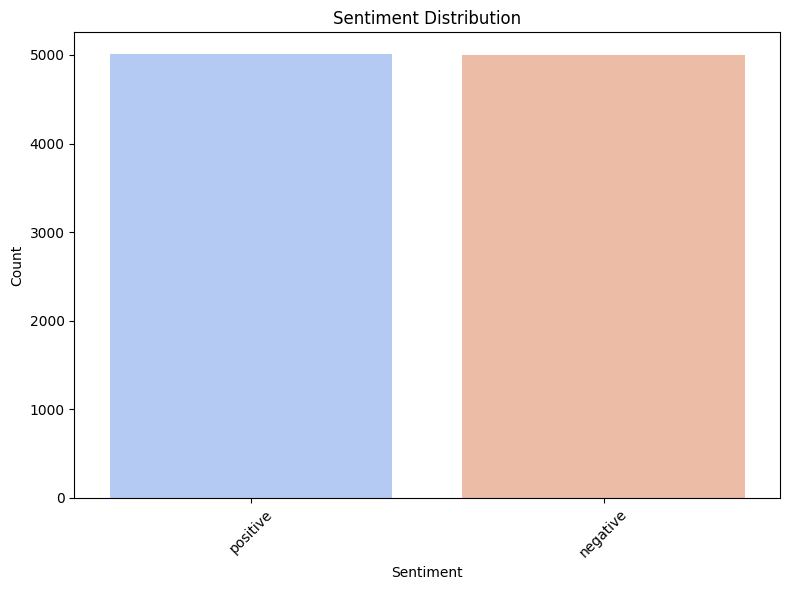

In [ ]:
# check sentiment distribution

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels if they are long
plt.tight_layout()
plt.show()


# Text preprocessing

Explanation:
text_cleaning: Removes HTML tags, special characters, and extra whitespace from the text.

lowercasing: Converts text to lowercase.

tokenization: Tokenizes text into words and sentences.

remove_stop_words: Removes common stop words using spaCy’s stop word list.

normalization: Lemmatizes tokens to their base forms using spaCy.

handle_punctuation: Removes punctuation from the text.

remove_numbers: Removes numbers from the text.

preprocess: A convenience method that applies all preprocessing steps sequentially.

In [ ]:
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc, Token

class TextPreprocessor:
    def __init__(self):
        # Load spaCy model
        self.nlp = spacy.load("en_core_web_sm")

    def text_cleaning(self, text: str) -> str:
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        # Remove special characters and extra whitespaces
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def lowercasing(self, text: str) -> str:
        return text.lower()

    def tokenization(self, text: str):
        doc = self.nlp(text)
        # Word Tokenization
        word_tokens = [token.text for token in doc]
        # Sentence Tokenization
        sentence_tokens = [sent.text for sent in doc.sents]
        return word_tokens, sentence_tokens

    def remove_stop_words(self, tokens):
        return [token for token in tokens if token.lower() not in STOP_WORDS]

    def normalization(self, tokens):
        doc = self.nlp(' '.join(tokens))
        # Lemmatization
        lemmatized_tokens = [token.lemma_ for token in doc]
        return lemmatized_tokens

    def handle_punctuation(self, text: str) -> str:
        return re.sub(r'[^\w\s]', '', text)

    def remove_numbers(self, text: str) -> str:
        return re.sub(r'\d+', '', text)


    def preprocess(self, text: str):
        # Apply all preprocessing steps
        text = self.text_cleaning(text)
        text = self.lowercasing(text)
        word_tokens, sentence_tokens = self.tokenization(text)
        word_tokens = self.remove_stop_words(word_tokens)
        word_tokens = self.normalization(word_tokens)
        text = ' '.join(word_tokens)
        text = self.handle_punctuation(text)
        text = self.remove_numbers(text)
        return text, word_tokens, sentence_tokens

In [ ]:
# check the preprocessing function
preprocessor = TextPreprocessor()
sample_text = "The quick brown fox jumps over the lazy dog. 123!"
cleaned_text, tokens, sentences = preprocessor.preprocess(sample_text)
print("Cleaned Text:", cleaned_text)
print("Tokens:", tokens)
print("Sentences:", sentences)

Cleaned Text: quick brown fox jump lazy dog 
Tokens: ['quick', 'brown', 'fox', 'jump', 'lazy', 'dog', '123']
Sentences: ['the quick brown fox jumps over the lazy dog 123']


I made a library based on this function os lets test it available at: https://pypi.org/project/text-processor-nlp/

In [ ]:
!pip install text-processor-nlp

In [ ]:
from text_processor_nlp import TextPreprocessor
processor = TextPreprocessor()
processor.preprocess(sample_text)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


('quick brown fox jump lazy dog ',
 ['quick', 'brown', 'fox', 'jump', 'lazy', 'dog', '123'],
 ['the quick brown fox jumps over the lazy dog 123'])

Now lets apply the TextPreprocessor class on our data

In [ ]:
# # Initialize the TextPreprocessor - dont run this
# preprocessor = TextPreprocessor()

# # Define a function to preprocess each review
# def preprocess_review(review):
#     cleaned_text, _, _ = preprocessor.preprocess(review)
#     return cleaned_text

# # Apply the preprocessing function to the 'review' column and store in 'cleaned_reviews'
# df['cleaned_reviews'] = df['review'].apply(preprocess_review)


Use **TQDM** to show progress bar

In [ ]:
from tqdm import tqdm

# Define a function to preprocess each review with a progress bar
def preprocess_reviews_with_progress(df, column_name):
    results = []
    for review in tqdm(df[column_name], desc="Processing reviews"):
        cleaned_text, _, _ = preprocessor.preprocess(review)
        results.append(cleaned_text)
    return results

# Apply the function and create the new column
df['cleaned_reviews'] = preprocess_reviews_with_progress(df, 'review')


Processing reviews:  98%|█████████▊| 9780/10000 [10:17<00:15, 13.90it/s]

In [ ]:
df['cleaned_reviews']

# Data Visualization

generic EDA

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Combine all text from the 'text' column into a single string
text = ' '.join(df['cleaned_reviews'].astype(str))


# Static Visualization: Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', random_state=42).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Word Cloud Visualization')
plt.show()

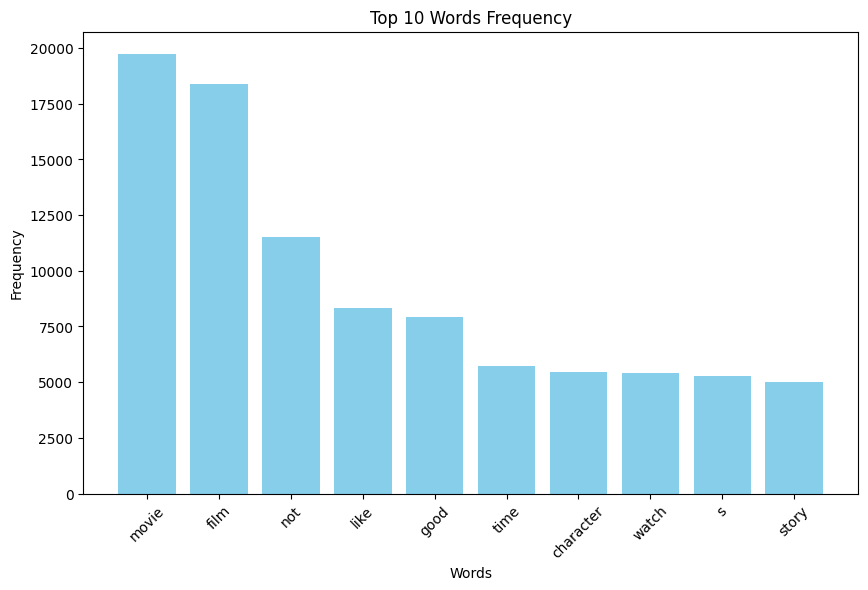

In [ ]:
# Split text into words
words = text.split()

# Count word frequencies
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Separate words and counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

For negative

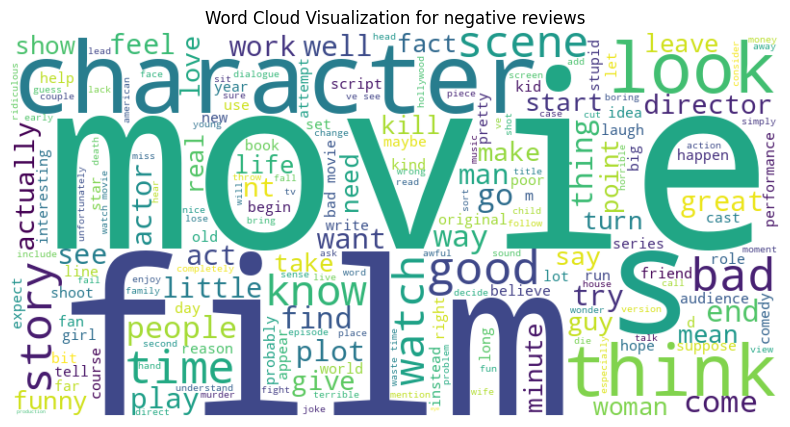

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Combine all text from the 'text' column into a single string
text = ' '.join(df[df.sentiment == 'negative']['cleaned_reviews'].astype(str))


# Static Visualization: Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', random_state=42).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Word Cloud Visualization for negative reviews')
plt.show()

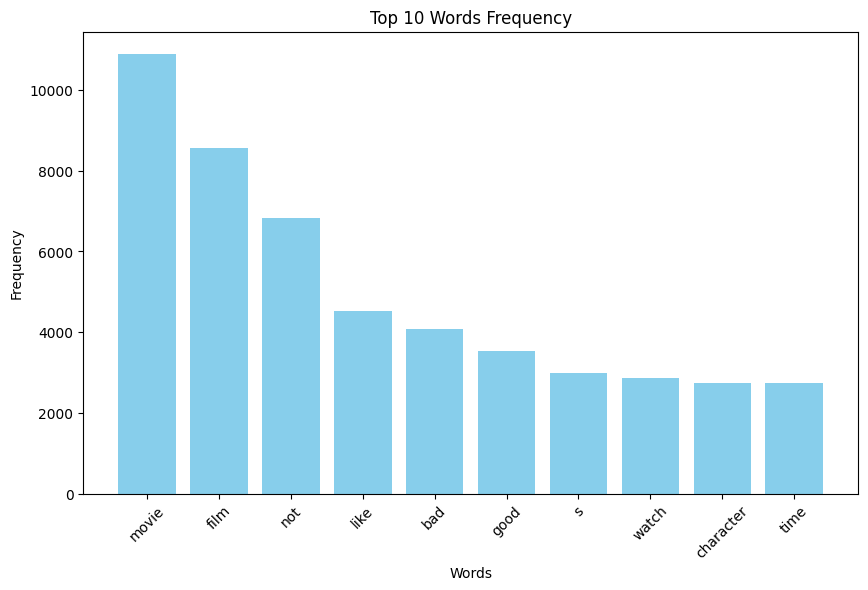

In [ ]:
# Split text into words
words = text.split()

# Count word frequencies
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Separate words and counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

For positive

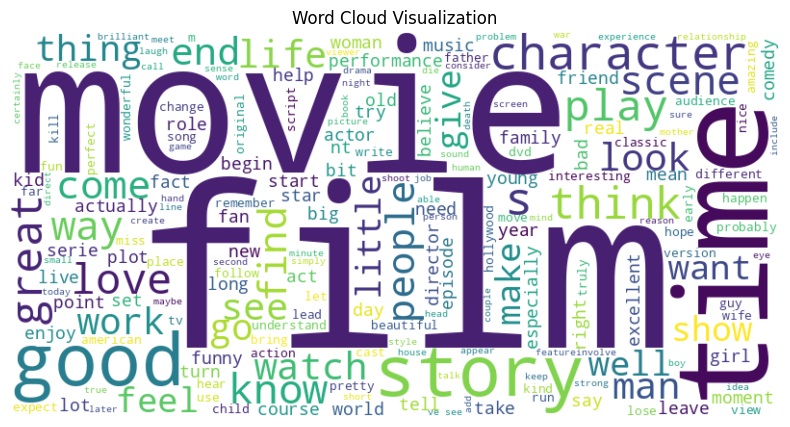

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Combine all text from the 'text' column into a single string
text = ' '.join(df[df.sentiment == 'positive']['cleaned_reviews'].astype(str))


# Static Visualization: Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', random_state=42).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.title('Word Cloud Visualization')
plt.show()

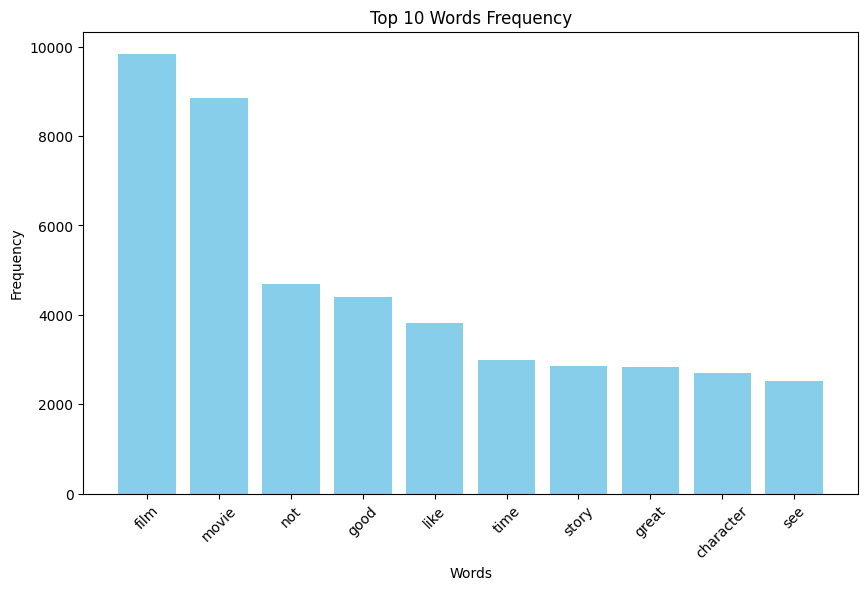

In [ ]:
# Split text into words
words = text.split()

# Count word frequencies
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Separate words and counts for plotting
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

Optional - do NER and POS tagging - Spacy

# Embedding

## Bag Of Words (BOW)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer



# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data to get a sparse matrix
X = vectorizer.fit_transform(df['cleaned_reviews'])

# Create a DataFrame with the sparse matrix and feature names
bow_df = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out())

bow_df


## TF-IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data to get a sparse matrix
X = vectorizer.fit_transform(df['cleaned_reviews'])

# Create a DataFrame with the sparse matrix and feature names
tfidf_df = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out())

tfidf_df

## Golve

In [ ]:
# download Glove embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
# Function to load GloVe embeddings
def load_glove_embeddings(file_path):
    # this function is returning a dictionary - with word as the key and its correspinding vector as value
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

# Function to get the average GloVe vector for a document
def get_average_glove_vector(text, embeddings, dim):
    # here we are getting the corresponding vector for our word from the dictionary that we made in the previoius funciton
    words = text.split()
    word_vectors = [embeddings.get(word, np.zeros(dim)) for word in words] # if a word is not present in the glove embedding then it will be assigned with a zeros array
    return np.mean(word_vectors, axis=0)

# Load GloVe embeddings (example with 50-dimensional vectors)
glove_embeddings = load_glove_embeddings('glove.6B.50d.txt')


# Get the dimension of GloVe vectors
embedding_dim = 50

# Compute average GloVe vectors for each document
df['glove_vectors'] = df['cleaned_reviews'].apply(lambda text: get_average_glove_vector(text, glove_embeddings, embedding_dim))

# Convert glove_vectors to DataFrame with separate columns for each dimension
glove_vectors_df = pd.DataFrame(df['glove_vectors'].tolist(), columns=[f'dim_{i}' for i in range(embedding_dim)])

glove_vectors_df


## Keras Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Initialize Tokenizer
tokenizer = Tokenizer()

# Fit Tokenizer on the text data
tokenizer.fit_on_texts(df['cleaned_reviews'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_reviews'])

# Pad sequences to ensure uniform length
max_sequence_length = 100 # or specify a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert to DataFrame for easier inspection
padded_sequences_df = pd.DataFrame(padded_sequences, columns=[f'word_{i+1}' for i in range(max_sequence_length)])

padded_sequences_df

# Modelling

In [ ]:
from sklearn.model_selection import train_test_split
x = padded_sequences_df
y = df['sentiment'].map({'positive': 0, 'negative': 1})

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Machine Learning

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


### Decision Tree

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression model
model = tree.DecisionTreeClassifier(max_depth=100)

# Train the model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression model
model = RandomForestClassifier(max_depth=100)

# Train the model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


## Deep Learning ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define the ANN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=8, validation_split=0.1)

# Evaluate the model
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Deep Learning with Recurrence

### RNN

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.4808 - loss: 0.7016 - val_accuracy: 0.4988 - val_loss: 0.7026
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.5124 - loss: 0.6936 - val_accuracy: 0.5013 - val_loss: 0.6922
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.6063 - loss: 0.6522 - val_accuracy: 0.6812 - val_loss: 0.5922
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.8450 - loss: 0.3670 - val_accuracy: 0.7425 - val_loss: 0.5645
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9202 - loss: 0.2095 - val_accuracy: 0.7138 - val_loss: 0.6535
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9593 - loss: 0.1188 - val_accuracy: 0.7312 - val_loss: 0.7462
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.9773 - loss: 0.0746 - val_accuracy: 0.7262 - val_loss: 0.9220
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.9810 - loss: 0.0554 - val_accurac

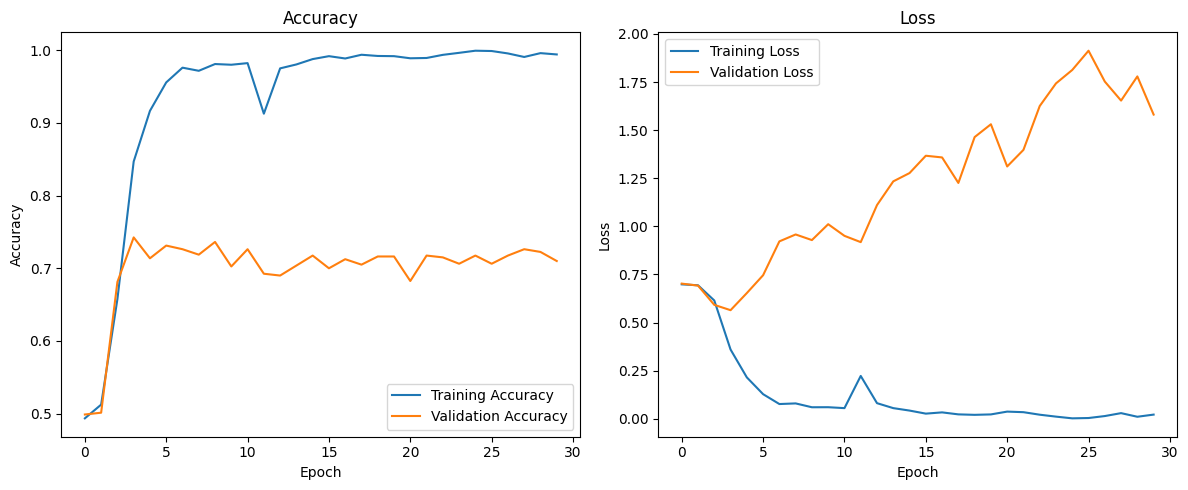

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report



# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=20, return_sequences=False))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=8, validation_split=0.1)

# Evaluate the model
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### LSTM

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6939 - loss: 0.5574 - val_accuracy: 0.8288 - val_loss: 0.3972
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9488 - loss: 0.1606 - val_accuracy: 0.8138 - val_loss: 0.4963
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9875 - loss: 0.0461 - val_accuracy: 0.7925 - val_loss: 0.6907
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9945 - loss: 0.0178 - val_accuracy: 0.8050 - val_loss: 0.7269
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.7887 - val_loss: 1.0467
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.7912 - val_loss: 1.0095
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9977 - loss: 0.0050 - val_accuracy: 0.7925 - val_loss: 1.0737
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accurac

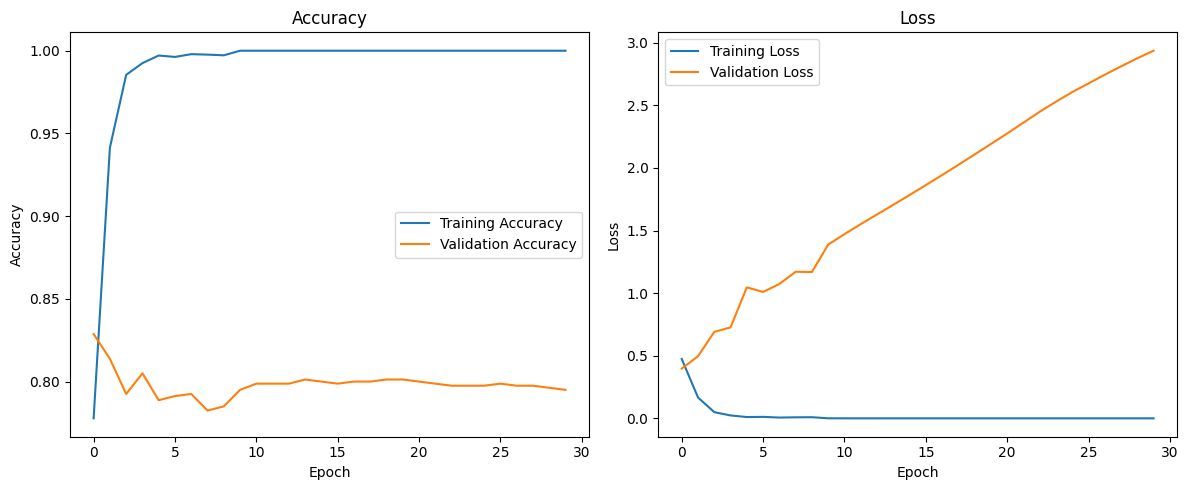

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report



# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=8, validation_split=0.1)

# Evaluate the model
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report



# Define the GRU model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=20, return_sequences=False))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=8, validation_split=0.1)

# Evaluate the model
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['positive', 'negative'])

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
